## Описание
#### Необходимо построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.
#### В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
#### Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
#### Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц.

#### Дополнительная информация
https://github.com/WillKoehrsen/feature-selector

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import sklearn
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime, date, time

# Импорт моделей
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import catboost


# Для пайплайна
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Построение и оценка модели
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
# Импортируем методы оценки важности фичей
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import pickle
import itertools

from utils import reduce_mem_usage, balance_df_by_target, get_classification_report, prepare_df_test, prepare_df_train
from utils import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, run_grid_search, run_cv, features_types


# Предупреждения и настройка столбцов
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

sklearn.show_versions()


System:
    python: 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]
executable: D:\anaconda3\python.exe
   machine: Windows-10-10.0.19044-SP0

Python dependencies:
          pip: 21.3.1
   setuptools: 58.0.4
      sklearn: 1.0
        numpy: 1.20.3
        scipy: 1.7.1
       Cython: None
       pandas: 1.3.3
   matplotlib: 3.4.3
       joblib: 1.0.1
threadpoolctl: 2.2.0

Built with OpenMP: True


In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Константы

RANDOM_STATE = 42
DATA_ROOT = Path('../mega_data/') #Корень от папки запуска скрипта
TRAIN_PATH = DATA_ROOT / 'data_train.csv'
TEST_PATH = DATA_ROOT / 'data_test.csv'
DATA_PATH = DATA_ROOT / 'features.csv'

## 1.1. Загрузка и оптимизация датасета

In [4]:
df_train = pd.read_csv(TRAIN_PATH)
df_train.drop('Unnamed: 0', axis=1, inplace=True)
df_train.head(3)

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0


In [5]:
df_test = pd.read_csv(TEST_PATH)
df_test.drop('Unnamed: 0', axis=1, inplace=True)
df_test.head()

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000
2,1099444,2.0,1546808400
3,1343255,5.0,1547413200
4,1277040,2.0,1546808400


In [6]:
%%time
data = pd.read_csv(DATA_PATH, sep='\t', index_col=[0])
data.head(3)

Wall time: 5min 9s


,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,49.520873,38.19189,-0.000725,-0.016435,-0.107041,-1.17746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-42.026959,-2841.496068,-1085.821501,-1755.674564,-89.504287,-119.724355,-70.712019,-54.069191,-16.642826,-7.896282,-5.634035,...,0.0,0.039208,0.665644,-0.008999,-11953.712824,-45175.257711,0.377099,-30.716053,-61790.157098,-0.243136,-42051.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,9.595373e+08,-42.014078,-4.405604e+08,1.356414e+09,5.565998,-1.465191,-33.302382,-249.128986,-36.772492,-0.364694,-0.133771,-0.209468,-32.356505,-109.884564,-876.69102,-5.368281,-247.110707,-108.409742,-512.437331,-84.617978,-17.295406,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,-6.783660,-26.544905,-2.736081,-4.007526,-2.558912,67.300873,55.97189,-0.000725,-0.016435,-0.107041,15.77254,-3.178521,411.379185,-10.744164,-0.094251,-0.001733,-0.009327,131.407791,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-192.026959,-2937.657200,-1181.982633,-1755.674564,447.193953,1258.981645,-119.662019,-54.602524,-65.059494,29.770382,-7.997875,...,0.0,0.039208,-0.334356,-0.008999,-1035.951824,-45175.257711,-0.622901,-30.716053,-61790.157098,0.756864,-39131.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,9.673997e+08,-39.474078,1.033869e+09,-1.204418e+08,5.232666,-0.465191,-33.302382,38.871014,4.227508,-0.364694,-0.133771,-0.209468,2.643495,-109.884564,-573.69102,3.631719,43.889293,-108.409742,-509.437331,-27.617978,-5.295406,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,-0.417924,-1.689642,-2.736081,9.226737,-2.558912,-66.189127,-69.87811,-0.000725,-0.016435,-0.107041,-5.41746,-0.638521,3.839185,8.855836,-0.094251,-0.001733,-0.009327,0.457791,0.200138,-0.00909,0.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,16.94061,-0.065583,1.839235,507.973041,11357.393596,5126.807163,6230.586136,-89.504287,-119.724355,-25.128689,-24.602526,-0.526164,-7.896282,-7.917057,...,0.0,0.039208,-0.334356,-0.008999,1109.231176,-45175.257711,0.377099,-30.716053,-61790.157098,0.756864,-41331.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,9.734477e+08,-55.744078,1.087204e+09,-1.204418e+08,-10.580668,-0.465191,-19.302382,149.871014,119.227508,-0.364694,-0.133771,-0.209468,123.643495,-109.884564,-873.69102,-2.368281,-247.110707,-108.409742,-512.437331,2232.382022,-17.295406,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [7]:
data.dtypes,data.shape

(id            int64
 buy_time      int64
 0           float64
 1           float64
 2           float64
              ...   
 248         float64
 249         float64
 250         float64
 251         float64
 252         float64
 Length: 255, dtype: object,
 (4512528, 255))

**Можно сократить размерность типов данных для уменьшения занимаемой памяти**

In [8]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

## 1.2. Первичный анализ датасетов и их подготовка

In [9]:
# Первоначальный датасет признаков содержит 4.5 млн. записей
data.shape, df_train.shape

((4512528, 255), (831653, 4))

In [10]:
df_test.shape, df_test['id'].unique().shape

((71231, 3), (70152,))

In [11]:
# Оставляем в датасете признаков только тех пользователей, которые есть или в train или в test
data = data.loc[(data['id'].isin(df_train['id'].values)) | ((data['id'].isin(df_test['id'].values)))]
data.shape, df_train.shape
# После матчинга датасет признаков содержит 902 тыс. записей

((902389, 255), (831653, 4))

In [12]:
%%time
data = reduce_mem_usage(data)

Wall time: 1min 31s


In [13]:
# Из них уникальных ID 
data['id'].unique().shape, df_train['id'].unique().shape, 

((872577,), (806613,))

In [14]:
# В датафрейме признаков есть дубликаты по ID с разными timestamp
duplicateRowsDF = data[data.duplicated(['id'])]
duplicateRowsDF.head(3)

,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
13476,859275,1542574800,178.230026,-70.779114,164.289215,-93.726799,158.871750,-114.831787,4.70382,18.083902,-4.715196,-22.659702,-2.736081,14.714010,-2.558912,188.050873,176.721893,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,10.045835,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,0.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,18.130610,-0.065583,-0.700765,-192.026962,1115.225586,-729.156433,1844.382080,-89.504288,-119.724358,-20.178688,-20.252523,0.073836,-7.896282,-5.442271,...,0.0,0.039208,-0.334356,-0.008999,3781.645264,-45175.257812,-0.622901,-30.716053,-61790.15625,0.756864,-41261.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,970078080.0,195.695923,1.050761e+09,-120441800.0,-7.300668,-1.465191,-33.30238,639.871033,14.227509,-0.364694,-0.133771,-0.209468,18.643496,-109.884567,-835.69104,-1.368281,-247.110703,-85.409744,-498.437317,-32.617977,-17.295406,1009.62616,1305.229248,-17.996269,55.369553,-102.747726,-21.832888,-0.694429,-12.175933,-0.45614,0.0
22959,3737178,1541970000,-96.799973,100.290886,21.459213,208.283203,16.041754,187.178207,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,118.259186,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2653.070312,-1184.422119,-1468.648193,-89.504288,-119.724358,-17.378689,-31.152525,13.773836,-7.896282,-7.997875,...,0.0,-0.960792,-0.334356,-0.008999,3571.608154,-45175.257812,-0.622901,-30.716053,-61790.15625,0.756864,-40031.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-572669504.0,-58.544079,1.068469e+09,-120441800.0,-1.800668,-1.465191,-33.30238,-241.128983,-13.772491,-0.364694,-0.133771,-0.209468,-9.356505,-109.884567,-862.69104,8.631719,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-937.37384,-599.770813,-5.996269,-37.630447,-163.747726,-22.832888,2.305572,-12.175933,-0.45614,1.0
35235,681886,1542574800,329.990021,18.610888,316.049225,-29.756798,310.631744,-50.861790,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,357.540863,346.211884,-0.000725,-0.016435,-0.107041,-5.41746,-0.118521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,0.977791,0.200138,-0.00909,1.648138,0.785634,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,407.973053,-2884.866211,-1143.236572,-1741.629639,-89.504288,-119.724358,-58.295349,-51.035858,-7.259494,-7.896282,-1.092987,...,0.0,0.039208,-0.334356,-0.008999,6721.715332,-45175.257812,0.377099,-30.716053,-61790.15625,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,969991680.0,365.185913,-4.405604e+08,-120441800.0,13.499332,8.534809,-33.30238,-258.128998,-33.772491,-0.364694,-0.133771,-0.209468,-29.356504,-109.884567,-875.69104,-4.368281,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-975.37384,-613.770813,-25.996269,-36.630447,-286.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0


In [15]:
duplicateRowsDF.shape

(29812, 255)

In [16]:
data.loc[data['id']==3737178]

,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
478,3737178,1542574800,-54.429970,142.660889,-62.440784,246.403198,-67.858246,225.298218,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-23.819126,-35.148109,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-8.010816,-10.744164,-0.094251,-0.001733,-0.009327,40.287792,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2881.578125,-1185.492432,-1696.085693,-89.504288,-119.724358,110.437981,-19.952526,130.390503,-7.896282,-7.813738,...,0.0,-0.960792,-0.334356,-0.008999,3571.608154,-45175.257812,-0.622901,-30.716053,-61790.15625,0.756864,-40031.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,970078080.0,-16.174078,1.068469e+09,-120441800.0,-1.800668,-1.465191,-33.30238,-261.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-860.69104,-0.368281,-236.110703,-108.409744,-512.437317,-106.617981,-17.295406,-959.37384,-613.770813,-20.996269,-37.630447,-300.747711,-24.832888,0.305571,-12.175933,-0.45614,1.0
22959,3737178,1541970000,-96.799973,100.290886,21.459213,208.283203,16.041754,187.178207,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,118.259186,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2653.070312,-1184.422119,-1468.648193,-89.504288,-119.724358,-17.378689,-31.152525,13.773836,-7.896282,-7.997875,...,0.0,-0.960792,-0.334356,-0.008999,3571.608154,-45175.257812,-0.622901,-30.716053,-61790.15625,0.756864,-40031.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-572669504.0,-58.544079,1.068469e+09,-120441800.0,-1.800668,-1.465191,-33.30238,-241.128983,-13.772491,-0.364694,-0.133771,-0.209468,-9.356505,-109.884567,-862.69104,8.631719,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-937.37384,-599.770813,-5.996269,-37.630447,-163.747726,-22.832888,2.305572,-12.175933,-0.45614,1.0


In [17]:
df_train.dtypes

id            int32
vas_id      float32
buy_time      int32
target      float32
dtype: object

In [18]:
# Генерируем concat столбцы для подсчета дубликатов
df_train['user_vas'] = df_train['id'].astype(str) + '_' + df_train['vas_id'].astype(str)
df_train['user_buytime'] = df_train['id'].astype(str) + '_' + df_train['buy_time'].astype(str)
df_train.head(3)

,id,vas_id,buy_time,target,user_vas,user_buytime
0,540968,8.0,1537131600,0.0,540968_8.0,540968_1537131600
1,1454121,4.0,1531688400,0.0,1454121_4.0,1454121_1531688400
2,2458816,1.0,1534107600,0.0,2458816_1.0,2458816_1534107600


In [19]:
# Оставляем дублирующие строки по разным услугам с одним buytime
df_train.loc[(df_train['user_buytime']=='3535386_1537736400')]

,id,vas_id,buy_time,target,user_vas,user_buytime
15814,3535386,4.0,1537736400,0.0,3535386_4.0,3535386_1537736400
15815,3535386,6.0,1537736400,1.0,3535386_6.0,3535386_1537736400


In [20]:
# В тестовом датасете есть дублирующие строки по одной и той же услуге с разным временем покупки
duplicateRowsDF = df_train[df_train.duplicated(['user_vas'])]
duplicateRowsDF.head(3)

,id,vas_id,buy_time,target,user_vas,user_buytime
53,675583,2.0,1542574800,1.0,675583_2.0,675583_1542574800
93,1825537,4.0,1544389200,0.0,1825537_4.0,1825537_1544389200
323,1010292,1.0,1542574800,1.0,1010292_1.0,1010292_1542574800


In [21]:
# Могут быть абсолютно одинаковые наблюдения в разные периоды времени с разным таргетом для одной и той же услуги
df_train.loc[(df_train['id']==1825537)]

,id,vas_id,buy_time,target,user_vas,user_buytime
92,1825537,4.0,1532898000,1.0,1825537_4.0,1825537_1532898000
93,1825537,4.0,1544389200,0.0,1825537_4.0,1825537_1544389200


In [22]:
# Из трейна их убираем дублирующие строки по одной и той же услуге с разным таргетом!
df_train = df_train.drop_duplicates('user_vas', keep="last")
df_train.shape
# Из 831 тыс строк осталось 825 тыс.

(825404, 6)

In [23]:
# Функция, которая мерджит тренировочный и тестовый датасеты с датасетом признаков с учетом поиска минимальной разницы во времени наблюдений
def merge_dfs(df, data):
    # добавляем столбец с конвертированной датой buy_time
    df['date_t'] = df['buy_time'].apply(lambda x: date.fromtimestamp(x))
    data['date_f'] = data['buy_time'].apply(lambda x: date.fromtimestamp(x))
    
    data['idx_f'] = data.index
    df['idx'] = df.index
    
    # объединяем по id
    df_merge = pd.merge(df, data, left_on='id', right_on='id')

    # столбец с разницей по времени
    df_merge['date_dif'] = np.abs(df_merge['date_t']-df_merge['date_f'])
    
    # группируем и оставляем строки, имеющие минимальную разницу
    res = df_merge.loc[df_merge.groupby(['idx'])['date_dif'].idxmin()]
    
    # удаляем, переименовываем столбцы
    res.drop(['buy_time_y', 'date_f', 'idx', 'idx_f', 'date_dif'], axis=1, inplace=True)
    
    res = res.rename(columns={'buy_time_x': 'buy_time', 'date_t': 'date'})

    res = res.reset_index(drop=True)
    
    return res

In [24]:
%%time
train_res = merge_dfs(df_train, data)

Wall time: 1min 15s


In [25]:
# Проверяем, что число строк не изменилось
train_res.shape

(825404, 260)

In [26]:
train_res.head()

,id,vas_id,buy_time,target,user_vas,user_buytime,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,...,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,1537131600,0.0,540968_8.0,540968_1537131600,2018-09-17,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,49.15382,195.883896,-1.835267,-12.831245,-2.736081,56.284081,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,54.495834,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,2.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,62.580612,-0.065583,-0.700765,-192.026962,239.787094,-1005.230652,1245.017822,-89.504288,-119.724358,...,0.0,0.039208,0.665644,-0.008999,-11953.712891,-45175.257812,-0.622901,-30.716053,-61790.156250,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,969818880.0,-49.224079,-4.405604e+08,-120441800.0,-8.634002,-1.465191,-33.30238,810.871033,270.227509,-0.364694,-0.133771,-0.209468,269.643494,-109.884567,364.308990,41.631718,938.889282,-108.409744,-504.437317,-53.617977,-12.295406,-845.37384,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0
1,1454121,4.0,1531688400,0.0,1454121_4.0,1454121_1531688400,2018-07-16,547.270020,238.430893,533.329224,274.803192,527.911743,253.698212,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,577.880859,566.551880,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2764.330078,-1102.746338,-1661.583740,-89.504288,-119.724358,...,0.0,0.039208,0.665644,-0.008999,10798.220703,-45175.257812,-0.622901,-30.716053,-61790.156250,0.756864,-37911.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,958586880.0,585.525940,1.072212e+09,-120441800.0,3.327904,-1.465191,-33.30238,-206.128983,-12.772491,-0.364694,-0.133771,-0.209468,-8.356505,-109.884567,-876.691040,-5.368281,-247.110703,-108.409744,-512.437317,-80.617981,-17.295406,-972.37384,-613.770813,-25.996269,-19.630449,-278.747711,-24.832888,-0.694429,-11.175933,-0.456140,0.0
2,2458816,1.0,1534107600,0.0,2458816_1.0,2458816_1534107600,2018-08-13,-92.139969,-95.469109,-106.080788,-139.596802,-111.498245,-142.901794,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-74.978111,-0.000725,-0.016435,-0.107041,-5.41746,-1.058521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-92.026962,-2761.896484,-1112.468994,-1649.427490,-89.504288,-119.724358,...,0.0,0.039208,0.665644,-0.008999,4972.062012,-45175.257812,0.377099,-30.716053,-61790.156250,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,-572669504.0,-58.544079,-4.405604e+08,-120441800.0,-6.314953,-1.465191,-33.30238,-266.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-703.691040,-5.368281,-247.110703,-108.409744,-339.437317,-106.617981,-17.295406,-977.37384,-613.770813,-25.996269,-37.630447,-304.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0
3,3535012,5.0,1535922000,0.0,3535012_5.0,3535012_1535922000,2018-09-03,54.880028,12.970888,54.079212,-9.116798,48.661755,-30.221790,60.17382,87.453903,-6.783660,-30.006538,73.523918,-4.007526,-2.558912,-9.829127,-2.098110,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-0.800815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,57.973042

## 2.1. Генерация новых фичей, оценка важности признаков

#Генерация списков признаков по типам (числовые, категориальные). Функция
def create_col_type_lists(train_res=train_res, cat_max=10):
    val_dict = train_res.nunique().to_dict()
    result = dict.fromkeys(['const', 'cat', 'num'])
    f_all = set(val_dict.keys())
    result['const'] = set({k:v for (k,v) in val_dict.items()  if v==1}.keys())
    result['cat'] = set({k:v for (k,v) in val_dict.items()  if v <= cat_max and v>1}.keys())
    result['num'] = f_all - result['const'] - result['cat']
        
    return list(result['num']), list(result['cat']), list(result['const'])

F_NUM, F_CAT, F_CONST = create_col_type_lists()
print(f'итого категориальных признаков: {len(F_CAT)}, числовых: {len(F_NUM)}, констант: {len(F_CONST)}')

for ind in F_CAT:
    print(ind, train_res[ind].unique())

for ind in F_CONST:
    print(ind, train_res[ind].unique())

F_CAT

F_CAT.remove('target')
F_CAT.remove('vas_id')


train_res = train_res.drop(columns=F_CONST, axis=1)
train_res[F_CAT] = train_res[F_CAT].astype('category')



In [29]:
# Удаляем лишние столбцы и генерим новые по дате
train_res.drop(['user_buytime', 'user_vas'], axis=1, inplace=True)
train_res['year'] = train_res['date'].map(lambda x: x.year)
train_res['month'] = train_res['date'].map(lambda x: x.month)
train_res['day'] = train_res['date'].map(lambda x: x.day)
train_res.drop(['date'], axis=1, inplace=True)

In [30]:
train_res.isnull().sum().sum()

0

In [31]:
train_res

,id,vas_id,buy_time,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,...,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,year,month,day
0,540968,8.0,1537131600,0.0,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,49.15382,195.883896,-1.835267,-12.831245,-2.736081,56.284081,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,54.495834,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,2.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,62.580612,-0.065583,-0.700765,-192.026962,239.787094,-1005.230652,1245.017822,-89.504288,-119.724358,-3.512019,33.247475,-36.759495,...,-0.008999,-11953.712891,-45175.257812,-0.622901,-30.716053,-61790.156250,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,969818880.0,-49.224079,-4.405604e+08,-120441800.0,-8.634002,-1.465191,-33.30238,810.871033,270.227509,-0.364694,-0.133771,-0.209468,269.643494,-109.884567,364.308990,41.631718,938.889282,-108.409744,-504.437317,-53.617977,-12.295406,-845.373840,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0,2018,9,17
1,1454121,4.0,1531688400,0.0,547.270020,238.430893,533.329224,274.803192,527.911743,253.698212,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,577.880859,566.551880,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2764.330078,-1102.746338,-1661.583740,-89.504288,-119.724358,-119.662018,-54.602524,-65.059494,...,-0.008999,10798.220703,-45175.257812,-0.622901,-30.716053,-61790.156250,0.756864,-37911.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,958586880.0,585.525940,1.072212e+09,-120441800.0,3.327904,-1.465191,-33.30238,-206.128983,-12.772491,-0.364694,-0.133771,-0.209468,-8.356505,-109.884567,-876.691040,-5.368281,-247.110703,-108.409744,-512.437317,-80.617981,-17.295406,-972.373840,-613.770813,-25.996269,-19.630449,-278.747711,-24.832888,-0.694429,-11.175933,-0.456140,0.0,2018,7,16
2,2458816,1.0,1534107600,0.0,-92.139969,-95.469109,-106.080788,-139.596802,-111.498245,-142.901794,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-74.978111,-0.000725,-0.016435,-0.107041,-5.41746,-1.058521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-92.026962,-2761.896484,-1112.468994,-1649.427490,-89.504288,-119.724358,-101.378685,-39.569191,-61.809494,...,-0.008999,4972.062012,-45175.257812,0.377099,-30.716053,-61790.156250,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,-572669504.0,-58.544079,-4.405604e+08,-120441800.0,-6.314953,-1.465191,-33.30238,-266.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-703.691040,-5.368281,-247.110703,-108.409744,-339.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-304.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0,2018,8,13
3,3535012,5.0,1535922000,0.0,54.880028,12.970888,54.079212,-9.116798,48.661755,-30.221790,60.17382,87.453903,-6.783660,-30.006538,73.523918,-4.007526,-2.558912,-9.829127,-2.098110,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-0.800815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,57.973042,-2406.325195,-650.650635,-1755.674561,-89.504288,-119.724358,-33.495354,-54.602524,21.107170,...,-0.008999,-11953.

train_res = pd.get_dummies(train_res, prefix='cat', drop_first=False)
col_names = train_res.columns

train_res.head()

In [32]:
X = train_res.drop(columns='target')
y = train_res['target']

In [33]:
# # Разбиение на тест-трейн по времени не дает прироста качества
# data_train = data_merged[data_merged.month.isin([9, 10, 11, 12])]
# data_test = data_merged[data_merged.month.isin([1])]

# X_train = data_train.drop(columns='target')
# X_test = data_test.drop(columns='target')

# y_train = data_train['target']
# y_test = data_test['target']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [35]:
# Есть дисбаланс классов, в трейне и тесте примерно одинаков
y_train.value_counts()[1] / y_train.value_counts()[0]

0.07556157865638106

In [36]:
y_test.value_counts()[1] / y_test.value_counts()[0]

0.07556053616880803

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((577782, 259), (247622, 259), (577782,), (247622,))

In [38]:

# Оцениваем 15 лучших, объясняющих целевую переменную, фичей
select = SelectKBest(k=15) 
selected_features = select.fit(X_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indices_selected]
X_train_selected = X_train[colnames_selected]
X_test_selected = X_test[colnames_selected]

colnames_selected

['id',
 'vas_id',
 'buy_time',
 '1',
 '3',
 '4',
 '5',
 '59',
 '192',
 '193',
 '207',
 '210',
 '224',
 'month',
 'day']

In [39]:
import gc
gc.collect()

4

In [40]:
# Значение признака разное в зависимости от предложенной услуги vas_id
table = train_res.pivot_table(values='1', columns='vas_id', aggfunc='median')
table

vas_id,1.0,2.0,4.0,5.0,6.0,7.0,8.0,9.0
1,-59.889111,-59.804111,-55.544113,-61.069111,-58.019112,-63.609112,-58.514114,-50.129112


In [41]:
table = train_res.pivot_table(values='3', columns='vas_id', aggfunc='median')
table

vas_id,1.0,2.0,4.0,5.0,6.0,7.0,8.0,9.0
3,-78.156799,-78.966797,-75.0168,-79.3368,-77.286797,-79.856796,-77.306801,-68.826797


In [42]:
table = train_res.pivot_table(values='5', columns='vas_id', aggfunc='median')
table

vas_id,1.0,2.0,4.0,5.0,6.0,7.0,8.0,9.0
5,-92.06179,-92.901787,-88.241791,-93.211792,-91.13179,-95.721786,-91.206787,-80.501793


In [43]:
table = train_res.pivot_table(values='59', columns='vas_id', aggfunc='median')
table

vas_id,1.0,2.0,4.0,5.0,6.0,7.0,8.0,9.0
59,-1.882665,-1.882665,-1.882665,-1.882665,-1.882665,-1.882665,-1.882665,-1.882665


In [44]:
table = train_res.pivot_table(values='193', columns='vas_id', aggfunc='median')
table

vas_id,1.0,2.0,4.0,5.0,6.0,7.0,8.0,9.0
193,-1.929048,-1.929048,-1.929048,-1.929048,-1.929048,-1.929048,-1.929048,-1.929048


In [45]:
table = train_res.pivot_table(values='207', columns='vas_id', aggfunc='median')
table

vas_id,1.0,2.0,4.0,5.0,6.0,7.0,8.0,9.0
207,-6768.625977,-6846.600586,-6357.891113,-6824.845215,-6331.209961,-6717.172363,-7021.155273,-5485.225586


In [46]:
train_res

,id,vas_id,buy_time,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,...,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,year,month,day
0,540968,8.0,1537131600,0.0,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,49.15382,195.883896,-1.835267,-12.831245,-2.736081,56.284081,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,54.495834,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,2.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,62.580612,-0.065583,-0.700765,-192.026962,239.787094,-1005.230652,1245.017822,-89.504288,-119.724358,-3.512019,33.247475,-36.759495,...,-0.008999,-11953.712891,-45175.257812,-0.622901,-30.716053,-61790.156250,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,969818880.0,-49.224079,-4.405604e+08,-120441800.0,-8.634002,-1.465191,-33.30238,810.871033,270.227509,-0.364694,-0.133771,-0.209468,269.643494,-109.884567,364.308990,41.631718,938.889282,-108.409744,-504.437317,-53.617977,-12.295406,-845.373840,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0,2018,9,17
1,1454121,4.0,1531688400,0.0,547.270020,238.430893,533.329224,274.803192,527.911743,253.698212,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,577.880859,566.551880,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2764.330078,-1102.746338,-1661.583740,-89.504288,-119.724358,-119.662018,-54.602524,-65.059494,...,-0.008999,10798.220703,-45175.257812,-0.622901,-30.716053,-61790.156250,0.756864,-37911.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,958586880.0,585.525940,1.072212e+09,-120441800.0,3.327904,-1.465191,-33.30238,-206.128983,-12.772491,-0.364694,-0.133771,-0.209468,-8.356505,-109.884567,-876.691040,-5.368281,-247.110703,-108.409744,-512.437317,-80.617981,-17.295406,-972.373840,-613.770813,-25.996269,-19.630449,-278.747711,-24.832888,-0.694429,-11.175933,-0.456140,0.0,2018,7,16
2,2458816,1.0,1534107600,0.0,-92.139969,-95.469109,-106.080788,-139.596802,-111.498245,-142.901794,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-74.978111,-0.000725,-0.016435,-0.107041,-5.41746,-1.058521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-92.026962,-2761.896484,-1112.468994,-1649.427490,-89.504288,-119.724358,-101.378685,-39.569191,-61.809494,...,-0.008999,4972.062012,-45175.257812,0.377099,-30.716053,-61790.156250,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,-572669504.0,-58.544079,-4.405604e+08,-120441800.0,-6.314953,-1.465191,-33.30238,-266.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-703.691040,-5.368281,-247.110703,-108.409744,-339.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-304.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0,2018,8,13
3,3535012,5.0,1535922000,0.0,54.880028,12.970888,54.079212,-9.116798,48.661755,-30.221790,60.17382,87.453903,-6.783660,-30.006538,73.523918,-4.007526,-2.558912,-9.829127,-2.098110,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-0.800815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,57.973042,-2406.325195,-650.650635,-1755.674561,-89.504288,-119.724358,-33.495354,-54.602524,21.107170,...,-0.008999,-11953.

In [48]:
#Значимые фичи
colnames_selected =['1', '3', '5', '207']
mm=pd.Series(pd.Series)
for ind in colnames_selected:
    mm[ind]=train_res.groupby(by="vas_id").agg(ind).median().rename('cat_'+ind)
for ind in colnames_selected:
    train_res = train_res.merge(mm[ind], how='left', on='vas_id',suffixes=('', '_y'))  

In [49]:
train_res.head()

,id,vas_id,buy_time,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,...,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,year,month,day,cat_1,cat_3,cat_5,cat_207
0,540968,8.0,1537131600,0.0,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,49.15382,195.883896,-1.835267,-12.831245,-2.736081,56.284081,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,54.495834,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,2.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,62.580612,-0.065583,-0.700765,-192.026962,239.787094,-1005.230652,1245.017822,-89.504288,-119.724358,-3.512019,33.247475,-36.759495,...,-30.716053,-61790.156250,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,969818880.0,-49.224079,-4.405604e+08,-120441800.0,-8.634002,-1.465191,-33.30238,810.871033,270.227509,-0.364694,-0.133771,-0.209468,269.643494,-109.884567,364.308990,41.631718,938.889282,-108.409744,-504.437317,-53.617977,-12.295406,-845.37384,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0,2018,9,17,-58.514114,-77.306801,-91.206787,-7021.155273
1,1454121,4.0,1531688400,0.0,547.270020,238.430893,533.329224,274.803192,527.911743,253.698212,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,577.880859,566.551880,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2764.330078,-1102.746338,-1661.583740,-89.504288,-119.724358,-119.662018,-54.602524,-65.059494,...,-30.716053,-61790.156250,0.756864,-37911.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,958586880.0,585.525940,1.072212e+09,-120441800.0,3.327904,-1.465191,-33.30238,-206.128983,-12.772491,-0.364694,-0.133771,-0.209468,-8.356505,-109.884567,-876.691040,-5.368281,-247.110703,-108.409744,-512.437317,-80.617981,-17.295406,-972.37384,-613.770813,-25.996269,-19.630449,-278.747711,-24.832888,-0.694429,-11.175933,-0.456140,0.0,2018,7,16,-55.544113,-75.016800,-88.241791,-6357.891113
2,2458816,1.0,1534107600,0.0,-92.139969,-95.469109,-106.080788,-139.596802,-111.498245,-142.901794,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-74.978111,-0.000725,-0.016435,-0.107041,-5.41746,-1.058521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-92.026962,-2761.896484,-1112.468994,-1649.427490,-89.504288,-119.724358,-101.378685,-39.569191,-61.809494,...,-30.716053,-61790.156250,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,-572669504.0,-58.544079,-4.405604e+08,-120441800.0,-6.314953,-1.465191,-33.30238,-266.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-703.691040,-5.368281,-247.110703,-108.409744,-339.437317,-106.617981,-17.295406,-977.37384,-613.770813,-25.996269,-37.630447,-304.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0,2018,8,13,-59.889111,-78.156799,-92.061790,-6768.625977
3,3535012,5.0,1535922000,0.0,54.880028,12.970888,54.079212,-9.116798,48.661755,-30.221790,60.17382,87.453903,-6.783660,-30.006538,73.523918,-4.007526,-2.558912,-9.829127,-2.098110,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-0.800815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,57.973042,-2406.325195,-650.650635,-1755.674561,-89.504288,-119.724358,-33.495354,-54.602524,21.107170,...,-18.006052,-

In [53]:
%%time
# Делаем балансировку датасета по методу smote
TARGET_NAME = 'target'
train_res_balanced = balance_df_by_target(train_res, TARGET_NAME, method='smote')

Wall time: 1min 51s


In [54]:
X = train_res_balanced.drop(columns='target')
y = train_res_balanced['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [55]:
y_train.value_counts()

0.0    537192
1.0    214876
Name: target, dtype: int64

In [56]:
y_train.value_counts()[1] / y_train.value_counts()[0]

0.3999985107745462

# 2.2. Использование FeatureSelector

https://github.com/WillKoehrsen/feature-selector

In [57]:
from feature_selector import FeatureSelector

In [58]:
fs = FeatureSelector(data = X_train, labels = y_train)

In [59]:
fs.identify_missing(missing_threshold=0.60)


0 features with greater than 0.60 missing values.



In [81]:
missing = fs.ops['missing']
missing

[]

In [60]:
fs.identify_single_unique()

6 features with a single unique value.



In [61]:
single_unique = fs.ops['single_unique']
single_unique

['75', '81', '85', '139', '203', 'year']

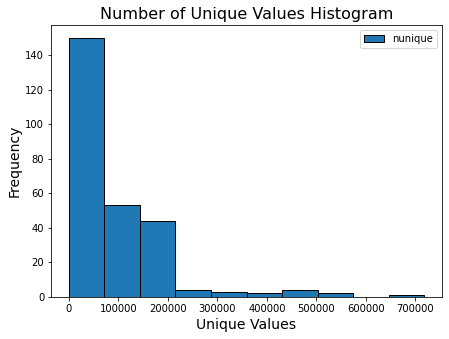

In [62]:
fs.plot_unique()

In [63]:
fs.unique_stats.sample(len(single_unique))

,nunique
162,118108
193,113590
198,75810
46,52734
90,1694
201,29495


In [64]:
fs.identify_collinear(correlation_threshold=0.975)

18 features with a correlation magnitude greater than 0.97.



In [65]:
correlated_features = fs.ops['collinear']
correlated_features

['2',
 '4',
 '33',
 '71',
 '72',
 '79',
 '112',
 '113',
 '116',
 '123',
 '124',
 '138',
 '142',
 '170',
 '186',
 '217',
 'month',
 'cat_5']

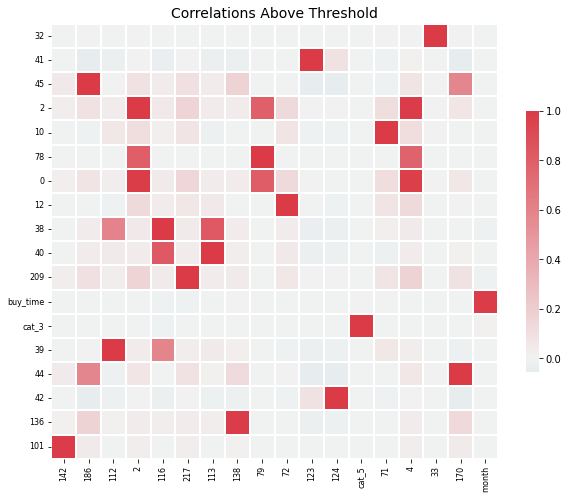

In [66]:
fs.plot_collinear()

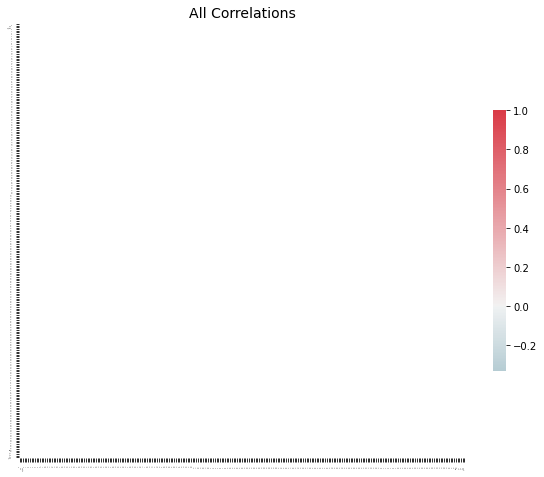

In [67]:
#fs.plot_collinear(plot_all=True)

In [68]:
%%time
fs.identify_zero_importance(task = 'classification', eval_metric = 'binary_logloss', 
                            n_iterations = 5, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[659]	valid_0's binary_logloss: 0.107691
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[719]	valid_0's binary_logloss: 0.108581
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[689]	valid_0's binary_logloss: 0.10879
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[716]	valid_0's binary_logloss: 0.108515
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[859]	valid_0's binary_logloss: 0.106462

17 features with zero importance after one-hot encoding.

Wall time: 8min 48s


In [69]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features

['23',
 '32',
 '33',
 '35',
 'year',
 '155',
 '203',
 '81',
 '139',
 '216',
 '218',
 '15',
 '75',
 '221',
 '95',
 '85',
 '24']

In [70]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 263 original features
There are 0 one-hot features


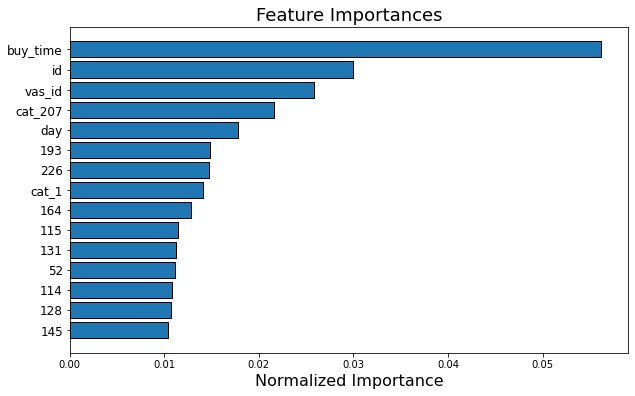

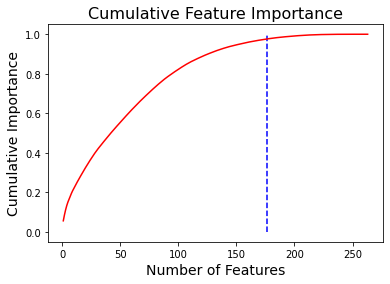

176 features required for 0.97 of cumulative importance


In [71]:
fs.plot_feature_importances(threshold = 0.975, plot_n = 15)

In [72]:
fs.feature_importances.head(15)

,feature,importance,normalized_importance,cumulative_importance
0,buy_time,1228.2,0.056205,0.056205
1,id,653.6,0.029910,0.086116
2,vas_id,563.8,0.025801,0.111917
3,cat_207,471.6,0.021582,0.133498
4,day,389.4,0.017820,0.151318
5,193,325.0,0.014873,0.166191
6,226,321.8,0.014726,0.180917
7,cat_1,308.2,0.014104,0.195021
8,164,280.0,0.012813,0.207835
9,115,249.4,0.011413,0.219248


In [73]:
fs.feature_importances.tail(15)

,feature,importance,normalized_importance,cumulative_importance
248,33,0.0,0.0,1.0
249,35,0.0,0.0,1.0
250,year,0.0,0.0,1.0
251,155,0.0,0.0,1.0
252,203,0.0,0.0,1.0
253,81,0.0,0.0,1.0
254,139,0.0,0.0,1.0
255,216,0.0,0.0,1.0
256,218,0.0,0.0,1.0
257,15,0.0,0.0,1.0


In [74]:
# Большая часть признаков имеют низкую важность
fs.identify_low_importance(cumulative_importance = 0.99)

197 features required for cumulative importance of 0.99 after one hot encoding.
66 features do not contribute to cumulative importance of 0.99.



In [75]:
low_importance_features = fs.ops['low_importance']
low_importance_features

['41',
 '190',
 '220',
 '232',
 '123',
 '22',
 '92',
 '105',
 '109',
 '215',
 '72',
 '120',
 '42',
 '82',
 '173',
 '161',
 '176',
 '153',
 '163',
 '80',
 '27',
 '124',
 '93',
 '91',
 '87',
 '206',
 '178',
 '197',
 '121',
 '86',
 '212',
 '78',
 '180',
 '179',
 '175',
 '79',
 '57',
 '84',
 '118',
 '154',
 '122',
 '16',
 '88',
 '202',
 '17',
 '83',
 '199',
 '177',
 '95',
 '221',
 '75',
 '15',
 '218',
 '216',
 '139',
 '81',
 '23',
 '155',
 'year',
 '35',
 '33',
 '32',
 '85',
 '31',
 '203',
 '24']

In [76]:
train_removed_all = fs.remove(methods = 'all', keep_one_hot=False)

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 79 features including one-hot features.


In [77]:
train_removed_all

,id,vas_id,buy_time,0,1,3,5,6,7,8,9,10,11,12,13,14,18,19,20,21,25,26,28,29,30,34,36,37,38,39,40,43,44,45,46,47,48,49,50,51,52,53,54,55,56,58,59,60,61,62,...,194,195,196,198,200,201,204,205,207,208,209,210,211,213,214,219,222,223,224,225,226,227,228,229,230,231,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,day,cat_1,cat_3,cat_207
29691,766196,2.000000,1544994000,81.170029,-162.409119,-176.936798,-198.041794,-16.086180,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,111.780876,100.451889,-5.41746,-3.178521,-5.050815,-10.744164,-2.082209,0.200138,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-192.026962,-2942.440430,-1186.765869,-1755.674561,-35.178680,-15.852520,-19.326160,-7.896282,-5.891306,-10.717958,-28.571102,-5.130284,-7.088986,-23.171711,4.668705,-1.958702,-4.745251,0.328676,-17.681646,-3.882665,-0.265234,0.221838,0.068356,...,-0.623737,0.771894,0.748041,0.566264,-0.02921,-0.104665,0.039208,0.665644,-11953.712891,-45175.257812,-0.622901,-30.716053,-61790.156250,-42051.167969,-9239.707031,-0.620772,961265280.0,119.425919,-4.405604e+08,-1.204418e+08,-5.191576,-1.465191,-33.30238,-266.128998,-39.772491,-0.364694,-0.209468,-35.356506,-109.884567,-876.691040,-5.368281,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.456140,1.0,17,-59.804111,-78.966797,-6846.600586
244991,2769160,9.000000,1542574800,-75.929970,-48.839111,-68.396797,-89.501793,-16.086180,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-56.648109,-5.41746,-3.178521,-5.040815,-10.744164,-2.082209,-0.799862,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-192.026962,-2942.440430,-1186.765869,-1755.674561,-107.512016,-54.602524,-52.909492,-7.896282,-6.280180,-10.717958,-28.571102,-13.130284,-18.088985,-31.171711,-7.331295,-4.958702,-6.745251,-1.671324,-20.681646,-0.882665,-0.265234,0.111838,0.038356,...,0.376263,-0.228106,-0.251959,0.566264,-0.02921,-0.104665,0.039208,-0.334356,3365.234131,-45175.257812,-0.622901,-30.716053,-61790.156250,-41361.167969,-9239.707031,-0.620772,-572669504.0,-58.544079,1.065416e+09,-1.204418e+08,6.899333,-1.465191,-33.30238,-266.128998,-39.772491,-0.364694,-0.209468,-35.356506,-109.884567,-876.691040,-5.368281,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0,19,-50.129112,-68.826797,-5485.225586
602797,691891,5.000000,1532293200,-90.869972,271.470886,879.843201,858.738220,-10.156180,-59.146095,-6.521167,-29.744045,-2.736081,1.659979,-2.558912,-66.189125,-77.518112,-5.41746,-3.178521,41.139183,-10.744164,-2.082209,0.200138,2.648138,0.785634,0.788392,-2.659389,-0.700765,-92.026962,-717.539001,-543.198425,-174.340561,595.571350,453.380829,142.190506,-7.896282,-7.997875,-10.715293,-28.570631,-8.130284,-13.088986,1.828289,-4.331295,-4.958702,-2.745251,-1.671324,-4.681646,0.117335,-0.185234,0.051838,0.048356,...,0.376263,-0.228106,0.748041,0.566264,-0.02921,-0.104665,0.039208,0.665644,8703.751953,-4921.257812,1.377099,-28.826052,-61810.765625,-42051.167969,-9239.707031,1.379228,-572669504.0,-58.544079,-4.405604e+08,-1.204418e+08,-10.827940,-1.465191,-33.30238,-13.128985,-13.772491,-0.364694,-0.209468,-9.356505,-109.884567,-332.691010,3.631719,62.889294,13.590259,-409.437317,-62.617977,-10.295406,-134.373840,72.229210,-25.996269,-21.630449,118.252274,-14.832889,5.305572,-7.175933,-0.456140,0.0,23,-61.069111,-79.336800,-6824.845215
579635,3058740,7.000000,1544389200,-96.799973,-247.159119,-299.766785,-320.871796,-16.086180,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-77.518112,-5.41746,-3.178521,-13.940815,-10.744164,-2.082209,0.200138,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-192.026962,-2942.440430,-1186.765869,-1755.674561,-49.728683,15.330810,-65.059494,-7.896282,-7.997875,-10.717958,-28.571102,-1.130284,-6.088986

In [85]:
drop_feat = list(set(missing+single_unique+zero_importance_features+low_importance_features))

In [89]:
drop_feat

['92',
 '41',
 '175',
 '83',
 '202',
 '123',
 '27',
 '178',
 '118',
 '82',
 '24',
 'year',
 '120',
 '42',
 '197',
 '155',
 '153',
 '88',
 '199',
 '75',
 '105',
 '203',
 '72',
 '86',
 '232',
 '121',
 '122',
 '16',
 '80',
 '95',
 '32',
 '177',
 '163',
 '173',
 '154',
 '22',
 '161',
 '176',
 '85',
 '78',
 '109',
 '91',
 '180',
 '190',
 '139',
 '33',
 '221',
 '220',
 '93',
 '87',
 '81',
 '218',
 '212',
 '23',
 '15',
 '215',
 '84',
 '31',
 '79',
 '35',
 '124',
 '206',
 '57',
 '179',
 '216',
 '17']

In [101]:
# Фиксируем и удаляем из датасета признаки с околонулевой значимостью

X_train = X_train.drop(drop_feat, axis=1)

### Финальный вид датасета

In [102]:
X_train

,id,vas_id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,18,19,20,21,25,26,28,29,30,34,36,37,38,39,40,43,44,45,46,47,48,49,50,51,52,53,54,55,56,58,59,60,...,198,200,201,204,205,207,208,209,210,211,213,214,217,219,222,223,224,225,226,227,228,229,230,231,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,month,day,cat_1,cat_3,cat_5,cat_207
29691,766196,2.000000,1544994000,81.170029,-162.409119,76.119217,-176.936798,70.701752,-198.041794,-16.086180,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,111.780876,100.451889,-5.41746,-3.178521,-5.050815,-10.744164,-2.082209,0.200138,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-192.026962,-2942.440430,-1186.765869,-1755.674561,-35.178680,-15.852520,-19.326160,-7.896282,-5.891306,-10.717958,-28.571102,-5.130284,-7.088986,-23.171711,4.668705,-1.958702,-4.745251,0.328676,-17.681646,-3.882665,-0.265234,...,0.566264,-0.02921,-0.104665,0.039208,0.665644,-11953.712891,-45175.257812,-0.622901,-30.716053,-61790.156250,-42051.167969,-9239.707031,-0.622896,-0.620772,961265280.0,119.425919,-4.405604e+08,-1.204418e+08,-5.191576,-1.465191,-33.30238,-266.128998,-39.772491,-0.364694,-0.209468,-35.356506,-109.884567,-876.691040,-5.368281,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.456140,1.0,12,17,-59.804111,-78.966797,-92.901787,-6846.600586
244991,2769160,9.000000,1542574800,-75.929970,-48.839111,-80.970787,-68.396797,-86.388245,-89.501793,-16.086180,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-56.648109,-5.41746,-3.178521,-5.040815,-10.744164,-2.082209,-0.799862,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-192.026962,-2942.440430,-1186.765869,-1755.674561,-107.512016,-54.602524,-52.909492,-7.896282,-6.280180,-10.717958,-28.571102,-13.130284,-18.088985,-31.171711,-7.331295,-4.958702,-6.745251,-1.671324,-20.681646,-0.882665,-0.265234,...,0.566264,-0.02921,-0.104665,0.039208,-0.334356,3365.234131,-45175.257812,-0.622901,-30.716053,-61790.156250,-41361.167969,-9239.707031,-0.622896,-0.620772,-572669504.0,-58.544079,1.065416e+09,-1.204418e+08,6.899333,-1.465191,-33.30238,-266.128998,-39.772491,-0.364694,-0.209468,-35.356506,-109.884567,-876.691040,-5.368281,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0,11,19,-50.129112,-68.826797,-80.501793,-5485.225586
602797,691891,5.000000,1532293200,-90.869972,271.470886,-49.730785,879.843201,-55.148247,858.738220,-10.156180,-59.146095,-6.521167,-29.744045,-2.736081,1.659979,-2.558912,-66.189125,-77.518112,-5.41746,-3.178521,41.139183,-10.744164,-2.082209,0.200138,2.648138,0.785634,0.788392,-2.659389,-0.700765,-92.026962,-717.539001,-543.198425,-174.340561,595.571350,453.380829,142.190506,-7.896282,-7.997875,-10.715293,-28.570631,-8.130284,-13.088986,1.828289,-4.331295,-4.958702,-2.745251,-1.671324,-4.681646,0.117335,-0.185234,...,0.566264,-0.02921,-0.104665,0.039208,0.665644,8703.751953,-4921.257812,1.377099,-28.826052,-61810.765625,-42051.167969,-9239.707031,1.377104,1.379228,-572669504.0,-58.544079,-4.405604e+08,-1.204418e+08,-10.827940,-1.465191,-33.30238,-13.128985,-13.772491,-0.364694,-0.209468,-9.356505,-109.884567,-332.691010,3.631719,62.889294,13.590259,-409.437317,-62.617977,-10.295406,-134.373840,72.229210,-25.996269,-21.630449,118.252274,-14.832889,5.305572,-7.175933,-0.456140,0.0,7,23,-61.069111,-79.336800,-93.211792,-6824.845215
579635,3058740,7.000000,1544389200,-96.799973,-247.159119,-110.740784,-299.766785,-116.158249,-320.871796,-16.086180,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-77.518112,-5.41746,-3.178521,-13.940815,-10.744164,-2.082209,0.200138,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-192.026962,-2942.440430,-1186.765869,-1755.674561,-49.728683,15.330810,-65.059494,-7.896282,-7.997875,-10.717958,-28.57110

In [104]:
X_train.shape

(752068, 197)

In [106]:
X_train.dtypes

id            int32
vas_id      float32
buy_time      int32
0           float32
1           float32
             ...   
day           int64
cat_1       float32
cat_3       float32
cat_5       float32
cat_207     float32
Length: 197, dtype: object

# 3.1. Baseline

### Добавляем необходимые фунции

In [107]:
feat_ok, feat_const, feat_categorical, feat_float = features_types(X_train)

In [112]:
print('f_all:', X_train.nunique().shape)
print('---------------')
print('feat_ok:', len(feat_ok))
print('feat_const:', len(feat_const))
print('feat_categorical:', len(feat_categorical))
print('feat_float:', len(feat_float))

f_all: (197,)
---------------
feat_ok: 197
feat_const: 0
feat_categorical: 1
feat_float: 196


In [109]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [111]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

### Pipeline для baseline модели LR

In [113]:
feat_prep_pipeline = make_pipeline(
    ColumnSelector(columns=feat_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(feat_float),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(feat_categorical),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)

In [114]:
%%time
feat_prep_pipeline.fit(X_train)

n_features = feat_prep_pipeline.transform(X_test).shape[1]
n_features

Wall time: 7.99 s


202

In [115]:
lr_estimator = make_pipeline(
    feat_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE, C=0.1, n_jobs=-1)
)

In [116]:
%%time
lr_estimator.fit(X_train, y_train)

Wall time: 1min 13s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['142', '186', '43',
                                                          '2', '160', '200',
                                                          '28', '223', '172',
                                                          '59', '213', '45',
                                                          '225', '66', '233',
                                                          '9', '89', '145',
                                                          '169', '60', '128',
                                                          '90', '39', '62',
                                                          '117', '140', '144',
                                                          '243', '244', '148', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',

In [117]:
%%time
lr_train_pred = lr_estimator.predict_proba(X_train)[:,1]
lr_test_pred = lr_estimator.predict_proba(X_test)[:,1]

In [119]:
%%time
fpr, tpr, roc_thresholds = roc_curve(y_test, lr_test_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, lr_test_pred)

Wall time: 203 ms


In [120]:
beta = 1 
fscore = (1+beta**2)*(precision * recall) / (beta**2*precision + recall)
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (pr_thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.259720, F-Score=0.783, Precision=0.689, Recall=0.908


^ значаения по таргету

Confusion matrix, without normalization
[[192464  37761]
 [  8487  83603]]


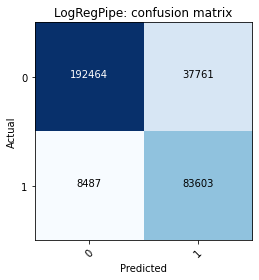

In [121]:
cm = confusion_matrix(y_test, lr_test_pred > pr_thresholds[ix])
plot_confusion_matrix(cm, classes=["0", "1"], model_name="LogRegPipe");

LogReg+Pipe: AUC_ROC = 0.920


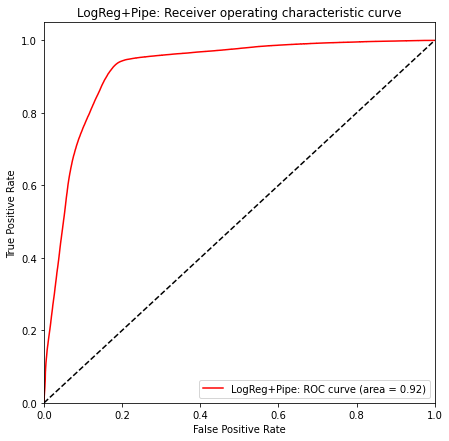

In [122]:
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "LogReg+Pipe", color='r')
print("LogReg+Pipe: AUC_ROC = %.3f" % auc(fpr, tpr))

In [123]:
print(classification_report(y_test, lr_test_pred > pr_thresholds[ix]))

              precision    recall  f1-score   support

         0.0       0.96      0.84      0.89    230225
         1.0       0.69      0.91      0.78     92090

    accuracy                           0.86    322315
   macro avg       0.82      0.87      0.84    322315
weighted avg       0.88      0.86      0.86    322315



In [124]:
get_classification_report(y_train, lr_train_pred, y_test, lr_test_pred, pr_thresholds[ix])

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.84      0.89    537192
         1.0       0.69      0.91      0.78    214876

    accuracy                           0.86    752068
   macro avg       0.82      0.87      0.84    752068
weighted avg       0.88      0.86      0.86    752068

TEST

              precision    recall  f1-score   support

         0.0       0.96      0.84      0.89    230225
         1.0       0.69      0.91      0.78     92090

    accuracy                           0.86    322315
   macro avg       0.82      0.87      0.84    322315
weighted avg       0.88      0.86      0.86    322315



### 3.2. Pipline XGBOOST

In [125]:
xgb_params = {"random_state": RANDOM_STATE,
                "n_estimators": 20,
                "max_depth": 7,
                "learning_rate": 0.05,
                "reg_lambda": 0.5,
                "reg_alpha": 0.5,
                "eval_metric": 'logloss'
             }

In [126]:
xgb_estimator = make_pipeline(
    feat_prep_pipeline,
    XGBClassifier(**xgb_params)
)

In [127]:
%%time
xgb_estimator.fit(X_train, y_train)

Wall time: 2min 46s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['142', '186', '43',
                                                          '2', '160', '200',
                                                          '28', '223', '172',
                                                          '59', '213', '45',
                                                          '225', '66', '233',
                                                          '9', '89', '145',
                                                          '169', '60', '128',
                                                          '90', '39', '62',
                                                          '117', '140', '144',
                                                          '243', '244', '148', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',

In [128]:
%%time
xgb_test_pred = xgb_estimator.predict_proba(X_test)[:,1]
xgb_train_pred = xgb_estimator.predict_proba(X_train)[:,1]

Wall time: 1min 16s


In [129]:
fpr, tpr, roc_thresholds = roc_curve(y_test, xgb_test_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, xgb_test_pred)

In [130]:
beta = 1 
fscore = (1+beta**2)*(precision * recall) / (beta**2*precision + recall)
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (pr_thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.467873, F-Score=0.893, Precision=0.868, Recall=0.920


^ значаения по таргету

Confusion matrix, without normalization
[[217340  12885]
 [  7630  84460]]


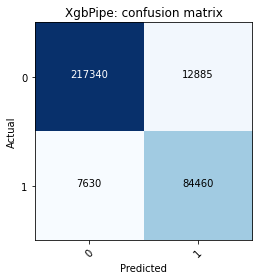

In [131]:
cm = confusion_matrix(y_test, xgb_test_pred > pr_thresholds[ix])
plot_confusion_matrix(cm, classes=["0", "1"], model_name="XgbPipe");

In [132]:
print(classification_report(y_test, xgb_test_pred > pr_thresholds[ix]))

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95    230225
         1.0       0.87      0.92      0.89     92090

    accuracy                           0.94    322315
   macro avg       0.92      0.93      0.92    322315
weighted avg       0.94      0.94      0.94    322315



In [133]:
# Модель не переобучилась, оценка на тесте высокая
get_classification_report(y_train, xgb_train_pred, y_test, xgb_test_pred, pr_thresholds[ix])

TRAIN

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96    537192
         1.0       0.87      0.92      0.89    214876

    accuracy                           0.94    752068
   macro avg       0.92      0.93      0.92    752068
weighted avg       0.94      0.94      0.94    752068

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95    230225
         1.0       0.87      0.92      0.89     92090

    accuracy                           0.94    322315
   macro avg       0.92      0.93      0.92    322315
weighted avg       0.94      0.94      0.94    322315



XGB+Pipe: AUC_ROC = 0.980


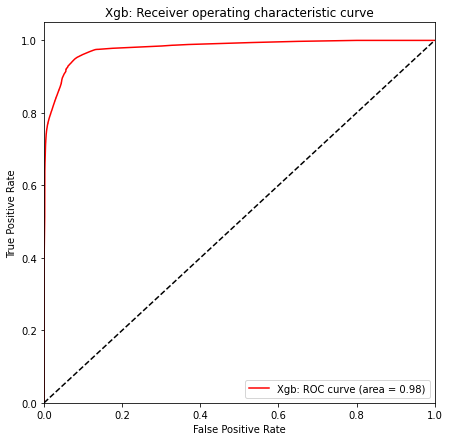

In [134]:
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Xgb", color='r')
print("XGB+Pipe: AUC_ROC = %.3f" % auc(fpr, tpr))

### 3.3. Pipeline CatBoos

In [135]:
X_train['vas_id'] = X_train['vas_id'].astype(int)
X_test['vas_id'] = X_test['vas_id'].astype(int)

In [136]:
catb_estimator = make_pipeline(
    feat_prep_pipeline,
    catboost.CatBoostClassifier(n_estimators=50, 
                                         max_depth=5, 
                                         l2_leaf_reg=5, 
#                                          cat_features=['id', 'vas_id'], 
                                         silent=True, 
                                         random_state=RANDOM_STATE)
    )

In [137]:
%%time
catb_estimator.fit(X_train, y_train)

Wall time: 45.5 s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['142', '186', '43',
                                                          '2', '160', '200',
                                                          '28', '223', '172',
                                                          '59', '213', '45',
                                                          '225', '66', '233',
                                                          '9', '89', '145',
                                                          '169', '60', '128',
                                                          '90', '39', '62',
                                                          '117', '140', '144',
                                                          '243', '244', '148', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',

In [138]:
%%time
catb_test_pred = catb_estimator.predict_proba(X_test)[:,1]
catb_train_pred = catb_estimator.predict_proba(X_train)[:,1]

Wall time: 21.7 s


In [139]:
fpr, tpr, roc_thresholds = roc_curve(y_test, catb_test_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, catb_test_pred)

In [140]:
beta = 1 
fscore = (1+beta**2)*(precision * recall) / (beta**2*precision + recall)
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (pr_thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.469059, F-Score=0.900, Precision=0.887, Recall=0.912


^ значения по таргету

CatBoost: AUC_ROC = 0.983


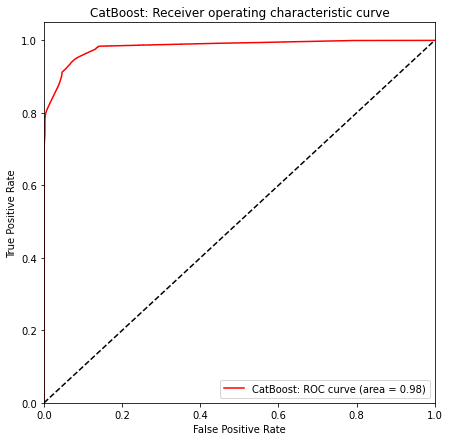

In [141]:
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "CatBoost", color='r')
print("CatBoost: AUC_ROC = %.3f" % auc(fpr, tpr))

Confusion matrix, without normalization
[[219557  10668]
 [  8066  84024]]


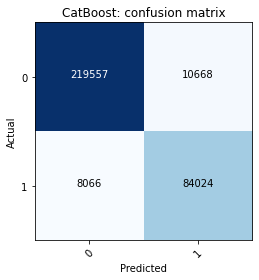

In [142]:
cm = confusion_matrix(y_test, catb_test_pred > pr_thresholds[ix])
plot_confusion_matrix(cm, classes=["0", "1"], model_name="CatBoost");

In [143]:
# Качество примерно такое же как в xgboost
get_classification_report(y_train, catb_train_pred, y_test, catb_test_pred, pr_thresholds[ix])

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96    537192
         1.0       0.89      0.91      0.90    214876

    accuracy                           0.94    752068
   macro avg       0.93      0.93      0.93    752068
weighted avg       0.94      0.94      0.94    752068

TEST

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96    230225
         1.0       0.89      0.91      0.90     92090

    accuracy                           0.94    322315
   macro avg       0.93      0.93      0.93    322315
weighted avg       0.94      0.94      0.94    322315



In [145]:
#train_res = None
gc.collect()

24149

## Лучший результат показал CatBoost

### 4.1. Применение на тестовом датасете

In [146]:
# Создаем объединенные столбцы в тестовом датасете
df_test['user_vas'] = df_test['id'].astype(str) + '_' + df_test['vas_id'].astype(str)
df_test['user_buytime'] = df_test['id'].astype(str) + '_' + df_test['buy_time'].astype(str)
df_test.head(3)

,id,vas_id,buy_time,user_vas,user_buytime
0,3130519,2.0,1548018000,3130519_2.0,3130519_1548018000
1,2000860,4.0,1548018000,2000860_4.0,2000860_1548018000
2,1099444,2.0,1546808400,1099444_2.0,1099444_1546808400


In [147]:
# В тестовом датасете есть дублирующие строки по одной и той же услуге с разным временем покупки
duplicateRowsDF = df_test[df_test.duplicated(['user_vas'])]
duplicateRowsDF.head(3)

,id,vas_id,buy_time,user_vas,user_buytime
1141,698739,6.0,1547413200,698739_6.0,698739_1547413200
2231,114110,4.0,1547413200,114110_4.0,114110_1547413200
3474,1782890,6.0,1547413200,1782890_6.0,1782890_1547413200


In [148]:
# !!!!!
df_test.loc[(df_test['id']==698739)]

,id,vas_id,buy_time,user_vas,user_buytime
1140,698739,6.0,1546808400,698739_6.0,698739_1546808400
1141,698739,6.0,1547413200,698739_6.0,698739_1547413200


In [149]:
df_test.shape

(71231, 5)

In [150]:
df_test = df_test.drop_duplicates('user_vas', keep="last")
df_test.shape

(71139, 5)

In [151]:
%%time
test_res = merge_dfs(df_test, data)

Wall time: 10.2 s


In [152]:
test_res.shape, test_res['id'].unique().shape

((71139, 259), (70152,))

In [153]:
test_res.drop(['user_buytime', 'user_vas'], axis=1, inplace=True)
test_res['year'] = test_res['date'].map(lambda x: x.year)
test_res['month'] = test_res['date'].map(lambda x: x.month)
test_res['day'] = test_res['date'].map(lambda x: x.day)
test_res.drop(['date'], axis=1, inplace=True)

In [154]:
test_res.shape

(71139, 259)

In [155]:
test_res

,id,vas_id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,...,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,year,month,day
0,3130519,2.0,1548018000,-62.899971,-374.279114,-72.600784,-418.406799,-78.018250,-439.511780,17.81382,-31.176098,-6.78366,-30.006538,31.163919,-4.007526,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-9.700815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-92.026962,-2847.354492,-1091.679932,-1755.674561,-89.504288,-119.724358,-88.778687,-35.052525,-53.726162,-7.896282,...,-0.008999,-11953.712891,10384.742188,0.377099,-30.716053,-61790.15625,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,-572669504.0,-58.544079,-4.405604e+08,-1.204418e+08,6.899333,-1.465191,-32.302380,-252.128983,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-876.69104,-5.368281,-247.110703,-108.409744,-512.437317,-84.617981,-17.295406,-970.373840,-613.770813,-25.996269,-37.630447,-258.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,2019,1,21
1,2000860,4.0,1548018000,-96.799973,100.290886,-110.740784,140.903198,-116.158249,119.798210,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2941.477539,-1186.665283,-1754.812256,-89.504288,-119.724358,-89.412018,-24.352526,-65.059494,-7.896282,...,-0.008999,15960.798828,559624.750000,-0.622901,-30.716053,-61790.15625,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-572669504.0,-58.544079,-4.405604e+08,-1.204418e+08,1.399332,-1.465191,-33.302380,-265.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-873.69104,-3.368281,-247.110703,-108.409744,-511.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-254.747726,-25.832888,-0.694429,-12.175933,-0.45614,0.0,2019,1,21
2,1099444,2.0,1546808400,-81.969971,-390.729126,-95.910789,-443.336792,-101.328247,-464.441803,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-64.808113,-0.000725,-0.016435,-0.107041,-5.41746,-1.058521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,-0.799862,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,407.973053,-2942.440430,-1186.765869,-1755.674561,-89.504288,-119.724358,-116.645355,-52.169193,-64.476158,-7.896282,...,-0.008999,-12274.540039,-45175.257812,0.377099,-30.716053,-61790.15625,0.756864,-42051.156250,-9239.707031,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,-572669504.0,-58.544079,1.065420e+09,-1.204418e+08,-6.100667,-1.465191,-33.302380,-266.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-876.69104,-5.368281,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,1.0,2019,1,7
3,1343255,5.0,1547413200,259.130035,-52.249111,245.189209,-104.856796,239.771759,-125.961792,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,289.740875,278.411896,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2942.440430,-1186.765869,-1755.674561,-89.504288,-119.724358,39.537983,41.74

In [164]:
# Добавляем медианные значения этих признаков в качестве фичей
colnames_selected =['1', '3', '5', '207']
mm=pd.Series(pd.Series)
for ind in colnames_selected:
    mm[ind]=test_res.groupby(by="vas_id").agg(ind).median().rename('cat_'+ind)
for ind in colnames_selected:
    test_res = test_res.merge(mm[ind], how='left', on='vas_id',suffixes=('', '_y'))

In [165]:
test_res

,id,vas_id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,...,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,year,month,day,cat_1,cat_3,cat_5,cat_207
0,3130519,2.0,1548018000,-62.899971,-374.279114,-72.600784,-418.406799,-78.018250,-439.511780,17.81382,-31.176098,-6.78366,-30.006538,31.163919,-4.007526,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-9.700815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-92.026962,-2847.354492,-1091.679932,-1755.674561,-89.504288,-119.724358,-88.778687,-35.052525,-53.726162,-7.896282,...,-30.716053,-61790.15625,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,-572669504.0,-58.544079,-4.405604e+08,-1.204418e+08,6.899333,-1.465191,-32.302380,-252.128983,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-876.69104,-5.368281,-247.110703,-108.409744,-512.437317,-84.617981,-17.295406,-970.373840,-613.770813,-25.996269,-37.630447,-258.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,2019,1,21,-62.839111,-79.426796,-93.881790,-6575.645508
1,2000860,4.0,1548018000,-96.799973,100.290886,-110.740784,140.903198,-116.158249,119.798210,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2941.477539,-1186.665283,-1754.812256,-89.504288,-119.724358,-89.412018,-24.352526,-65.059494,-7.896282,...,-30.716053,-61790.15625,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-572669504.0,-58.544079,-4.405604e+08,-1.204418e+08,1.399332,-1.465191,-33.302380,-265.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-873.69104,-3.368281,-247.110703,-108.409744,-511.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-254.747726,-25.832888,-0.694429,-12.175933,-0.45614,0.0,2019,1,21,-48.034111,-70.726799,-82.306793,-5504.885254
2,1099444,2.0,1546808400,-81.969971,-390.729126,-95.910789,-443.336792,-101.328247,-464.441803,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-64.808113,-0.000725,-0.016435,-0.107041,-5.41746,-1.058521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,-0.799862,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,407.973053,-2942.440430,-1186.765869,-1755.674561,-89.504288,-119.724358,-116.645355,-52.169193,-64.476158,-7.896282,...,-30.716053,-61790.15625,0.756864,-42051.156250,-9239.707031,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,-572669504.0,-58.544079,1.065420e+09,-1.204418e+08,-6.100667,-1.465191,-33.302380,-266.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-876.69104,-5.368281,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,1.0,2019,1,7,-62.839111,-79.426796,-93.881790,-6575.645508
3,1343255,5.0,1547413200,259.130035,-52.249111,245.189209,-104.856796,239.771759,-125.961792,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,289.740875,278.411896,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2942.440430,-1186.765869,-1755.674561,-89.504288,-119.724358,39.5379

In [166]:
# Удаляем из датасета признаки с околонулевой значимостью

test_res = test_res.drop(drop_feat, axis=1)

In [167]:
test_res

,id,vas_id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,18,19,20,21,25,26,28,29,30,34,36,37,38,39,40,43,44,45,46,47,48,49,50,51,52,53,54,55,56,58,59,60,...,198,200,201,204,205,207,208,209,210,211,213,214,217,219,222,223,224,225,226,227,228,229,230,231,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,month,day,cat_1,cat_3,cat_5,cat_207
0,3130519,2.0,1548018000,-62.899971,-374.279114,-72.600784,-418.406799,-78.018250,-439.511780,17.81382,-31.176098,-6.78366,-30.006538,31.163919,-4.007526,-2.558912,-66.189125,-77.518112,-5.41746,-3.178521,-9.700815,-10.744164,-2.082209,0.200138,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-92.026962,-2847.354492,-1091.679932,-1755.674561,-88.778687,-35.052525,-53.726162,-7.896282,-7.997875,-10.361439,-28.563688,-17.130283,-22.088985,-48.171711,-25.331295,-4.958702,-8.745251,-1.671324,-24.681646,-3.882665,0.524766,...,-0.433736,-0.02921,-0.104665,0.039208,-0.334356,-11953.712891,10384.742188,0.377099,-30.716053,-61790.15625,-42051.167969,-9239.707031,0.377104,0.379228,-572669504.0,-58.544079,-4.405604e+08,-1.204418e+08,6.899333,-1.465191,-32.302380,-252.128983,-39.772491,-0.364694,-0.209468,-35.356506,-109.884567,-876.69104,-5.368281,-247.110703,-108.409744,-512.437317,-84.617981,-17.295406,-970.373840,-613.770813,-25.996269,-37.630447,-258.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,1,21,-62.839111,-79.426796,-93.881790,-6575.645508
1,2000860,4.0,1548018000,-96.799973,100.290886,-110.740784,140.903198,-116.158249,119.798210,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-77.518112,-5.41746,-3.178521,-13.940815,-10.744164,-2.082209,0.200138,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-192.026962,-2941.477539,-1186.665283,-1754.812256,-89.412018,-24.352526,-65.059494,-7.896282,-7.997875,-10.717958,-28.571102,-4.130284,-9.088986,-10.171711,0.668705,-4.958702,-9.745251,-1.671324,-14.681646,-2.882665,-0.265234,...,0.566264,-0.02921,0.895335,0.039208,0.665644,15960.798828,559624.750000,-0.622901,-30.716053,-61790.15625,-42051.167969,-9239.707031,-0.622896,-0.620772,-572669504.0,-58.544079,-4.405604e+08,-1.204418e+08,1.399332,-1.465191,-33.302380,-265.128998,-39.772491,-0.364694,-0.209468,-35.356506,-109.884567,-873.69104,-3.368281,-247.110703,-108.409744,-511.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-254.747726,-25.832888,-0.694429,-12.175933,-0.45614,0.0,1,21,-48.034111,-70.726799,-82.306793,-5504.885254
2,1099444,2.0,1546808400,-81.969971,-390.729126,-95.910789,-443.336792,-101.328247,-464.441803,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-64.808113,-5.41746,-1.058521,-13.940815,-10.744164,-2.082209,-0.799862,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,407.973053,-2942.440430,-1186.765869,-1755.674561,-116.645355,-52.169193,-64.476158,-7.896282,-3.784615,-10.717958,-28.571102,51.869717,51.911015,25.828289,-21.331295,0.041298,-4.745251,-1.671324,-13.681646,-1.882665,-0.265234,...,0.566264,-0.02921,-0.104665,0.039208,-0.334356,-12274.540039,-45175.257812,0.377099,-30.716053,-61790.15625,-42051.156250,-9239.707031,0.377104,0.379228,-572669504.0,-58.544079,1.065420e+09,-1.204418e+08,-6.100667,-1.465191,-33.302380,-266.128998,-39.772491,-0.364694,-0.209468,-35.356506,-109.884567,-876.69104,-5.368281,-247.110703,-108.409744,-512.437317,-106.617981,-17.295406,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,1.0,1,7,-62.839111,-79.426796,-93.881790,-6575.645508
3,1343255,5.0,1547413200,259.130035,-52.249111,245.189209,-104.856796,239.771759,-125.961792,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,289.740875,278.411896,-5.41746,-3.178521,-13.940815,-10.744164,-2.082209,0.200138,-0.351862,-0.214366,-0.211608,-2.659389,-0.700765,-192.026962,-2942.440430,-1186.765869,-1755.674561,39.537983,41.747475,-2.209494,-7.896282,-5.762134,-10.717958,-28.571102,-17.130283,-22.088985,-48.

In [177]:
preds1 = xgb_estimator.predict_proba(test_res)[:,1]
preds2 = catb_estimator.predict_proba(test_res)[:,1]

In [178]:
result1 = pd.concat([test_res['id'], test_res['vas_id'], test_res['buy_time'], pd.Series(preds1)], axis=1)
result2 = pd.concat([test_res['id'], test_res['vas_id'], test_res['buy_time'], pd.Series(preds2)], axis=1)

In [179]:
# применить treshold = 0.49 как на трейне
result1 = result1.rename(columns={0: 'target'})
result1

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0.815427
1,2000860,4.0,1548018000,0.514979
2,1099444,2.0,1546808400,0.815427
3,1343255,5.0,1547413200,0.818358
4,1277040,2.0,1546808400,0.815427
...,...,...,...,...
71134,2502453,5.0,1548018000,0.818358
71135,1693213,2.0,1548018000,0.815427
71136,1891350,2.0,1548018000,0.815427
71137,2437172,2.0,1548018000,0.815427


In [180]:
# применить treshold = 0.49 как на трейне
result2 = result2.rename(columns={0: 'target'})
result2

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0.169647
1,2000860,4.0,1548018000,0.434355
2,1099444,2.0,1546808400,0.205688
3,1343255,5.0,1547413200,0.514199
4,1277040,2.0,1546808400,0.209793
...,...,...,...,...
71134,2502453,5.0,1548018000,0.469015
71135,1693213,2.0,1548018000,0.176800
71136,1891350,2.0,1548018000,0.172899
71137,2437172,2.0,1548018000,0.176229


In [181]:
result

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0.169647
1,2000860,4.0,1548018000,0.434355
2,1099444,2.0,1546808400,0.205688
3,1343255,5.0,1547413200,0.514199
4,1277040,2.0,1546808400,0.209793
...,...,...,...,...
71134,2502453,5.0,1548018000,0.469015
71135,1693213,2.0,1548018000,0.176800
71136,1891350,2.0,1548018000,0.172899
71137,2437172,2.0,1548018000,0.176229


In [193]:
date_time = datetime.now()


In [194]:
# Сохранение в csv
result1.to_csv(DATA_ROOT / ('answers_test1_'+date_time.strftime("%Y%m%d_%H%M")+'.csv'), encoding="utf-8-sig", sep=';', index=False)
result2.to_csv(DATA_ROOT / ('answers_test2_'+date_time.strftime("%Y%m%d_%H%M")+'.csv'), encoding="utf-8-sig", sep=';', index=False)

### 4.2. Сохранение финальной модели

In [195]:
with open('./models.pickle', 'wb') as file:
          pickle.dump(catb_estimator, file)

In [196]:
with open('./models.pickle', 'rb') as model_file:
    model = pickle.load(model_file)
        
preds = model.predict_proba(test_res)[:,1]
result = pd.concat([test_res['id'], test_res['vas_id'], test_res['buy_time'], pd.Series(preds)], axis=1)
result = result.rename(columns={0: 'target'})



In [208]:
# Сохранение в csv
result.to_csv('answers_test.csv', encoding="utf-8-sig", sep=';', index=False)

### 4.3. Применение на тренировочном датасете без балансировки

In [201]:
DROP_FEAT = ['92', '41', '175', '83', '202', '123', '27', '178', '118', '82', '24', 'year', '120', '42', '197', '155', 
             '153', '88', '199', '75', '105', '203', '72', '86', '232', '121', '122', '16', '80', '95', '32', '177', '163', 
             '173', '154', '22', '161', '176', '85', '78', '109', '91', '180', '190', '139', '33', '221', '220', '93', 
             '87', '81', '218', '212', '23', '15', '215', '84', '31', '79', '35', '124', '206', '57', '179', '216', '17']

BEST_SELECTED =['1', '3', '5', '207']

train_res = merge_dfs(df_train, data)

train_res.drop(['user_buytime', 'user_vas'], axis=1, inplace=True)
train_res['year'] = train_res['date'].map(lambda x: x.year)
train_res['month'] = train_res['date'].map(lambda x: x.month)
train_res['day'] = train_res['date'].map(lambda x: x.day)
train_res.drop(['date'], axis=1, inplace=True)

#Значимые фичи
mm=pd.Series(pd.Series)
for ind in BEST_SELECTED:
    mm[ind]=train_res.groupby(by="vas_id").agg(ind).median().rename('cat_'+ind)
    train_res = train_res.merge(mm[ind], how='left', on='vas_id',suffixes=('', '_y'))  
    

# Удаляем из датасета признаки с околонулевой значимостью
train_res = train_res.drop(DROP_FEAT, axis=1)

X = train_res.drop(columns='target')
y = train_res['target']

with open("./models.pickle", 'rb') as model_file:
    model = pickle.load(model_file)

train_preds = model.predict_proba(X)[:,1]

In [202]:
fpr, tpr, roc_thresholds = roc_curve(y, train_preds)
precision, recall, pr_thresholds = precision_recall_curve(y, train_preds)

In [203]:
beta = 1 
fscore = (1+beta**2)*(precision * recall) / (beta**2*precision + recall)
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (pr_thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.496312, F-Score=0.556, Precision=0.506, Recall=0.617


Confusion matrix, without normalization
[[732520  34897]
 [ 22183  35804]]


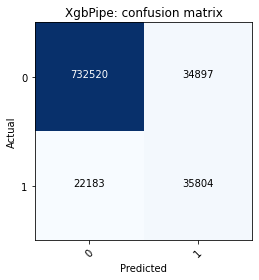

In [204]:
cm = confusion_matrix(y, train_preds > pr_thresholds[ix])
plot_confusion_matrix(cm, classes=["0", "1"], model_name="XgbPipe");

In [205]:
print(classification_report(y, train_preds > pr_thresholds[ix]))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96    767417
         1.0       0.51      0.62      0.56     57987

    accuracy                           0.93    825404
   macro avg       0.74      0.79      0.76    825404
weighted avg       0.94      0.93      0.93    825404



XGB+Pipe: AUC_ROC = 0.924


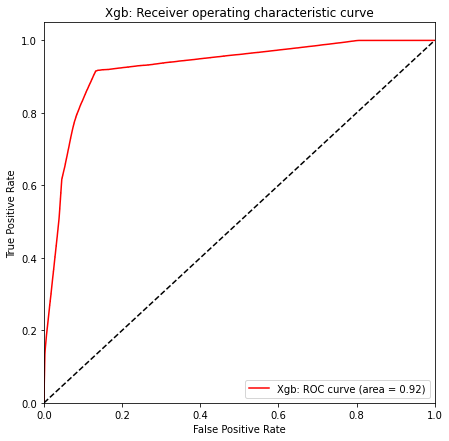

In [206]:
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Xgb", color='r')
print("XGB+Pipe: AUC_ROC = %.3f" % auc(fpr, tpr))

In [207]:
result.to_csv('answers_train_'+date_time.strftime("%Y%m%d_%H%M")+'.csv', encoding="utf-8-sig", sep=';', index=False)